In [20]:
# Import
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import requests
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import optuna
from optuna.integration import XGBoostPruningCallback
import xgboost as xgb
import torch
from scipy import stats
from sklearn.metrics import r2_score
import warnings
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_math_sdp(True)

In [2]:
def get_sp500_tickers():
    """Guncel S&P 500 Listesini cekelim."""

    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    tables = pd.read_html(response.text)
    df = tables[0]
    
    tickers = df['Symbol'].tolist()
    # Stock Price isimlendirme duzeltmesi
    tickers = [t.replace('.', '-') for t in tickers]
    return tickers

tickers = get_sp500_tickers()
print("",len(tickers), "\n",tickers[:10])

 503 
 ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [3]:
def download_data(start_date, end_date, tickers):
    """
    Belirtilen tarih araliginda Adjusted Close ve Volume verilerini indirelim.
    """
    print(f"{len(tickers)} hisse icin veri indiriliyor...")

    # yfinance ile verileri indirelim.
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

    prices = data.xs('Close', level=1, axis=1)
    volumes = data.xs('Volume', level=1, axis=1)
    return prices, volumes


# Tarih aralığı
START_DATE = "2010-01-01"
END_DATE   = "2024-12-31"

# S&P 500 güncel tickersları alalım.
tickers = get_sp500_tickers()

# Fiyat ve volume datasını çekelim.
prices_df, volumes_df = download_data(START_DATE, END_DATE, tickers)

# Eksik verisi olan stock price'ları çıkaralım. (Burada survivorship bias oluşturuyoruz ancak bunu raporumuz ekleriz.)
valid_columns = prices_df.columns[prices_df.notna().sum() > (len(prices_df) * 0.8)]
prices_df = prices_df[valid_columns]
volumes_df = volumes_df[valid_columns]

print("Veriler indirildi.")
print(f"prices_df.shape: {prices_df.shape}")
print(prices_df.head())

503 hisse icin veri indiriliyor...


[*****************     36%                       ]  183 of 503 completed$Q: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[**********************47%                       ]  237 of 503 completed$SNDK: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['Q', 'SNDK']: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")


Veriler indirildi.
prices_df.shape: (3773, 448)
Ticker           TECH   CBRE       VRSN        PFG         WM        TMO  \
Date                                                                       
2010-01-04  14.670556  13.82  20.826298  14.712373  22.794479  44.983414   
2010-01-05  14.544528  14.15  21.045170  15.059593  22.694391  45.134937   
2010-01-06  14.506083  14.03  20.817879  14.959546  22.687721  45.561089   
2010-01-07  14.540253  14.17  20.531664  15.089013  22.741100  45.561089   
2010-01-08  14.512487  14.20  20.691610  15.106668  22.847864  46.328171   

Ticker           BF-B        PSA      NFLX        CME  ...        TXT  \
Date                                                   ...              
2010-01-04  10.752120  44.479256  0.764000  36.433624  ...  18.441807   
2010-01-05  10.640201  44.845596  0.735857  36.403835  ...  18.093119   
2010-01-06  10.788096  44.573624  0.761714  36.156971  ...  18.722692   
2010-01-07  10.682172  44.512554  0.748571  36.201679 

In [4]:
def calculate_returns(prices_df):
    """
    Log getirileri hesaplar.
    Veri kaybını önlemek için dropna() argümanını değiştiriyoruz.
    """
    returns = np.log(prices_df / prices_df.shift(1))
    
    # Sadece TÜM hisselerin boş olduğu satırları (örn: resmi tatiller) sil.
    # Tek bir hisse eksik diye günü silme.
    return returns.dropna(how='all')

# PCA kodunda PCA oncesi standardization ekledim.
def get_pca_residuals(returns_df, n_components=15, window=252):
    """
    PCA Residuals hesaplar. Veriyi standardize eder (Z-Score), 
    böylece PCA varyans yerine korelasyon yapısını yakalar.
    Makalede genellikle n_components 10-50 arası denenir (Guijarro et al. 15-50 arası kullanıyor).
    """

    residuals = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
    # Performans için numpy array'e çevirip işlem yapacağız, sonra dataframe'e basacağız
    residuals_values = np.full(returns_df.shape, np.nan)
    
    print(f"PCA Residual hesaplanıyor... (Toplam {len(returns_df) - window} gün işlenecek)")
    
    data_values = returns_df.values
    
    # PCA Modeli
    pca = PCA(n_components=n_components)

    for t in range(window, len(returns_df)):
        if t % 500 == 0: print(f"İşlenen gün: {t}")

        # 1. Eğitim Verisi (Geçmiş Window)
        # t dahil DEĞİL (t-window ... t-1) -> Look-ahead bias yok.
        train_data = data_values[t-window : t]
        
        # 2. NaN Kontrolü
        # O pencerede herhangi bir NaN'ı olan hisseyi o gün için dışarıda bırakalım
        valid_idx = ~np.isnan(train_data).any(axis=0)
        
        # O günkü getiri (Target) de NaN olmamalı
        target_valid = ~np.isnan(data_values[t])
        valid_idx = valid_idx & target_valid

        if np.sum(valid_idx) < n_components + 1:
            continue
            
        # Geçerli veriyi seç
        X_train = train_data[:, valid_idx]
        y_test = data_values[t, valid_idx].reshape(1, -1) # Bugünün getirisi
        
        # 3. Standardizasyon (ÖNEMLİ ADIM)
        # PCA'nın scale'den etkilenmemesi için.
        # Mean ve Std'yi sadece TRAIN setten öğreniyoruz.
        scaler_mean = np.mean(X_train, axis=0)
        scaler_std = np.std(X_train, axis=0) + 1e-8 # Sıfıra bölünme hatasını önle
        
        X_train_scaled = (X_train - scaler_mean) / scaler_std
        
        # PCA Fit
        pca.fit(X_train_scaled)
        
        # 4. Tahmin ve Residual
        # Bugünün verisini de AYNI mean/std ile standardize etmeliyiz
        y_test_scaled = (y_test - scaler_mean) / scaler_std
        
        # Faktörlere indirge
        factors = pca.transform(y_test_scaled)
        
        # Geri oluştur (Reconstruct)
        reconstructed_scaled = pca.inverse_transform(factors)
        
        # Scaled Residual
        res_scaled = y_test_scaled - reconstructed_scaled
        
        # Residual'ı tekrar orijinal getiri uzayına (log-return scale) döndür
        # Formül: Res_raw = Res_scaled * std 
        # (Mean eklemeye gerek yok çünkü residual farktır, mean'ler birbirini götürür)
        res_raw = res_scaled * scaler_std
        
        residuals_values[t, valid_idx] = res_raw.flatten()

    residuals_df = pd.DataFrame(residuals_values, index=returns_df.index, columns=returns_df.columns)
    return residuals_df

In [5]:
returns_df = calculate_returns(prices_df)

# Cap outliers
# returns_df = returns_df.clip(lower=returns_df.quantile(0.05), upper=returns_df.quantile(0.95), axis=1)

# Calculate residuals
residuals_df = get_pca_residuals(returns_df, n_components=5, window=252) # window size 252 - 500 denenebilir.

for col in residuals_df.columns:
    residuals_df[col] = residuals_df[col].astype(np.float64)

residuals_df = residuals_df.dropna(how='all')
print(residuals_df.tail())

PCA Residual hesaplanıyor... (Toplam 3520 gün işlenecek)
İşlenen gün: 500
İşlenen gün: 1000
İşlenen gün: 1500
İşlenen gün: 2000
İşlenen gün: 2500
İşlenen gün: 3000
İşlenen gün: 3500
Ticker          TECH      CBRE      VRSN       PFG        WM       TMO  \
Date                                                                     
2024-12-23 -0.005633  0.007149  0.007333  0.000190 -0.009485  0.004058   
2024-12-24 -0.003243  0.001358  0.002058 -0.005053  0.000752  0.001599   
2024-12-26 -0.002094 -0.001826  0.003793  0.006458 -0.000473 -0.006467   
2024-12-27  0.004581 -0.003354  0.010807  0.000077  0.002429  0.003418   
2024-12-30  0.009682  0.008541  0.016312  0.002158 -0.001332 -0.000219   

Ticker          BF-B       PSA      NFLX       CME  ...       TXT      HBAN  \
Date                                                ...                       
2024-12-23 -0.025780  0.004122 -0.001842 -0.001448  ... -0.005769 -0.005279   
2024-12-24 -0.007122  0.000064  0.014120  0.003131  ...  0.000

In [6]:
# Residual sanity checks
print("Mean residual:", np.nanmean(residuals_df.values))
print("Std residual:", np.nanstd(residuals_df.values))

# Cross-sectional correlation (ortalama)
cs_corr = residuals_df.corr().values
print("Avg abs cross-sec corr:", np.nanmean(np.abs(cs_corr[np.triu_indices_from(cs_corr, 1)])))


Mean residual: 1.6545876778968095e-05
Std residual: 0.014244478299599208
Avg abs cross-sec corr: 0.0320590142847791


--- Özet İstatistikler ---
Ortalama Varyans Açıklama Oranı (R^2): %48.53
(Yani hisse hareketlerinin %49'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)
Ortalama Piyasa Korelasyonu (Ham Getiri): 0.602
Ortalama Piyasa Korelasyonu (Residuals):  0.004 (Sıfıra yakın olmalı)


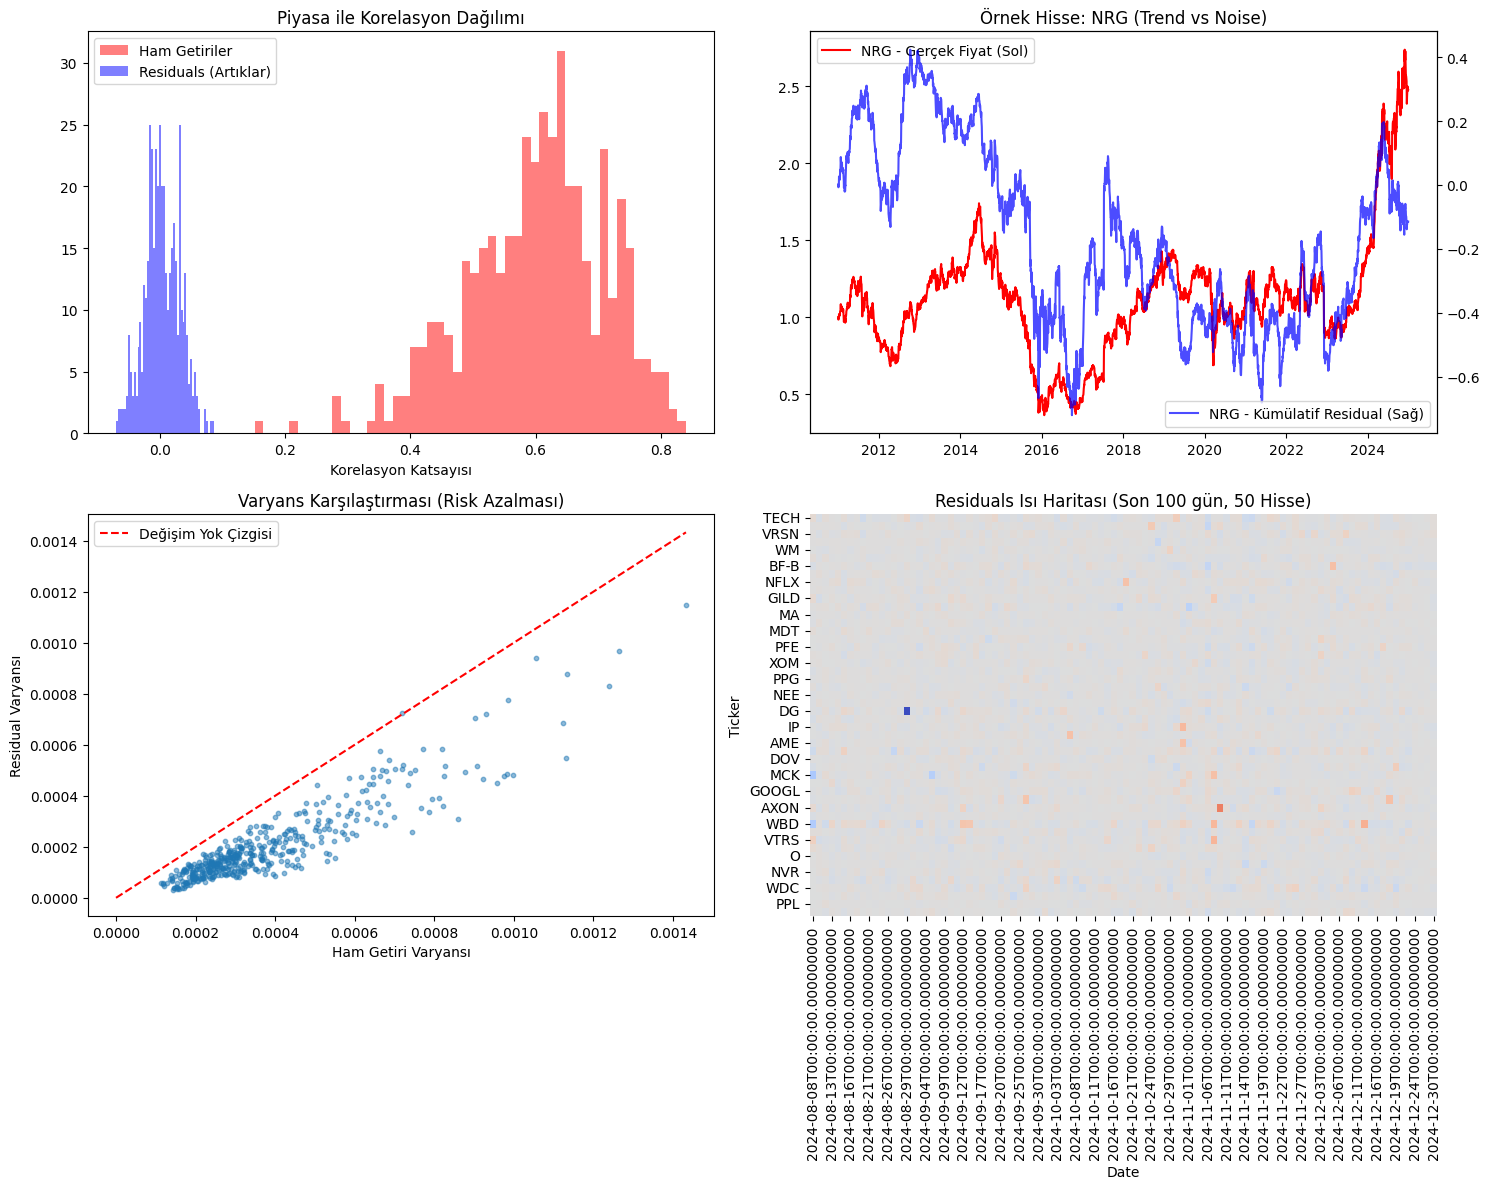

In [7]:
def analyze_residuals(returns_df, residuals_df):
    """
    Orijinal getiriler ile PCA sonrası artıkları (residuals) karşılaştırır.
    """
    
    # Ortak tarihleri hizalayalım (Residuals ilk window kadar boştur)
    valid_dates = residuals_df.dropna(how='all').index
    ret_clean = returns_df.loc[valid_dates]
    res_clean = residuals_df.loc[valid_dates]
    
    # Piyasa Proxy'si Oluşturma (Equal Weighted Index)
    # S&P 500 endeks verisi yerine, elimizdeki hisselerin ortalamasını "Piyasa" kabul edelim.
    market_return = ret_clean.mean(axis=1)
    
    # Varyans Azalması (R-Kare Benzeri Analiz)
    # Formül: 1 - (Var(Residual) / Var(Raw))
    # Bu bize "PCA faktörleri varyansın % kaçını açıkladı?" bilgisini verir.
    var_raw = ret_clean.var()
    var_res = res_clean.var()
    variance_explained = 1 - (var_res / var_raw)
    
    print(f"--- Özet İstatistikler ---")
    print(f"Ortalama Varyans Açıklama Oranı (R^2): %{variance_explained.mean()*100:.2f}")
    print(f"(Yani hisse hareketlerinin %{variance_explained.mean()*100:.0f}'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)")
    
    # Piyasa ile Korelasyon Analizi
    # Her bir hissenin piyasa ile korelasyonunu hesapla
    corr_raw = ret_clean.corrwith(market_return)
    corr_res = res_clean.corrwith(market_return)
    
    print(f"Ortalama Piyasa Korelasyonu (Ham Getiri): {corr_raw.mean():.3f}")
    print(f"Ortalama Piyasa Korelasyonu (Residuals):  {corr_res.mean():.3f} (Sıfıra yakın olmalı)")

    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Grafik A: Korelasyon Dağılımı (Histogram)
    axes[0, 0].hist(corr_raw, bins=50, alpha=0.5, label='Ham Getiriler', color='red')
    axes[0, 0].hist(corr_res, bins=50, alpha=0.5, label='Residuals (Artıklar)', color='blue')
    axes[0, 0].set_title('Piyasa ile Korelasyon Dağılımı')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Korelasyon Katsayısı')
    
    # Grafik B: Rastgele Bir Hissenin Kümülatif Getirisi vs Residual
    # Rastgele bir hisse seçelim
    sample_stock = ret_clean.columns[np.random.randint(0, len(ret_clean.columns))]
    
    cum_ret = (1 + ret_clean[sample_stock]).cumprod()
    cum_res = res_clean[sample_stock].cumsum() # Residuals log-return olduğu için toplanır (yaklaşık)
    
    ax2 = axes[0, 1]
    ax2.plot(cum_ret.index, cum_ret, label=f'{sample_stock} - Gerçek Fiyat (Sol)', color='red')
    ax2_r = ax2.twinx()
    ax2_r.plot(cum_res.index, cum_res, label=f'{sample_stock} - Kümülatif Residual (Sağ)', color='blue', alpha=0.7)
    ax2.set_title(f'Örnek Hisse: {sample_stock} (Trend vs Noise)')
    ax2.legend(loc='upper left')
    ax2_r.legend(loc='lower right')
    
    # Grafik C: Volatilite Karşılaştırması
    axes[1, 0].scatter(var_raw, var_res, alpha=0.5, s=10)
    axes[1, 0].plot([0, var_raw.max()], [0, var_raw.max()], 'r--', label='Değişim Yok Çizgisi')
    axes[1, 0].set_title('Varyans Karşılaştırması (Risk Azalması)')
    axes[1, 0].set_xlabel('Ham Getiri Varyansı')
    axes[1, 0].set_ylabel('Residual Varyansı')
    axes[1, 0].legend()
    
    # Grafik D: Residual Isı Haritası (İlk 50 hisse, son 100 gün)
    # Kümeleşme var mı diye bakıyoruz
    import seaborn as sns
    sns.heatmap(res_clean.iloc[-100:, :50].T, ax=axes[1, 1], cmap='coolwarm', center=0, cbar=False)
    axes[1, 1].set_title('Residuals Isı Haritası (Son 100 gün, 50 Hisse)')
    
    plt.tight_layout()
    plt.show()


analyze_residuals(returns_df, residuals_df)

Derin öğrenme modelleri (CNN, Transformer), verideki desenleri (pattern) çok iyi öğrenir. Normalizasyon yaptığınızda:

- Deseni Korursunuz: "Fiyat düştü, sonra toparladı" şeklindeki hareketi (V formasyonu gibi) model hala görebilir. Bu harika.

- Genliği (Magnitude) Yok Edersiniz: Hareketin ne kadar şiddetli olduğu bilgisi (standart sapmaya bölündüğü için) kaybolur.Ancak hedef değişkeniniz ($y$) ham getiri olduğu için, genlik bilgisi hayati önem taşır.

Çözüm Nedir?

- Bilgiyi Geri Ver (Benim Önerdiğim):Modele normalize edilmiş grafiği verin (böylece şekli öğrensin), ama yanına ek bir özellik (feature) olarak "Standart Sapma" değerini de verin.
    - Girdi: [Normalize Grafik, 0.01] $\rightarrow$ Model anlar: "Şekil yukarı bakıyor ama katsayısı küçük, tahminim düşük olmalı."
    - Girdi: [Normalize Grafik, 0.10] $\rightarrow$ Model anlar: "Şekil yukarı bakıyor ve katsayısı büyük, tahminim yüksek olmalı."

- Hedefi de Normalize Et (Alternatif): Modelden ham getiriyi ($y$) değil, Sharpe Oranını ($y / \sigma$) tahmin etmesini isteyin.
    - Hisse A Hedefi: $0.005 / 0.01 = 0.5$
    - Hisse B Hedefi: $0.050 / 0.10 = 0.5$
    - Bu durumda model girdileri aynı olduğu için çıktıları da aynı (0.5) tahmin eder ve hata yapmaz. Tahmin sonrası gerçek paraya dönmek için model çıktısını tekrar o günün volatilitesi ile çarparsınız.


Sizin durumunuzda CNN+Transformer kullanacağımız ve makalede genelde Sharpe odaklı gidildiği için, Volatilite bilgisini modele ayrı bir kanal veya feature olarak vermek en sağlam yöntemdir.

## OU BASELINE MODEL

In [8]:

# Bunu silecegiz asagidaki duzgun calisirsa !
def create_ou_sequences(residuals_df, window_size=30):
    """
    Residuals DataFrame'ini OU Modeli için hazırlar.
    DEĞİŞİKLİKLER:
    1. Veri kümülatif toplama (Fiyat serisi) çevrildi.
    2. Normalizasyon KALDIRILDI (OU kendi parametrelerini tahmin etmeli).
    3. Çıktı boyutu (Samples, Window) yapıldı (3D gerekmez).
    """
    
    # 1. Adım: Residual'ları Kümülatif Fiyata Çevir (OU Seviye Bazlıdır)
    # NaN'ları 0 ile dolduruyoruz ki kümülatif toplam bozulmasın.
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    # DataFrame'i Numpy'a çevir
    data = prices_df.values
    num_days, num_stocks = data.shape
    
    X_list = []
    y_list = [] # OU için aslında 'y' (target) gerekmez ama backtest için sonraki günün getirisini tutalım.
    
    # Residuals DF orijinal halini de alalım (Target hesabı için günlük getiri lazım)
    raw_residuals = residuals_df.fillna(0.0).values
    
    print(f"OU Veri Seti oluşturuluyor... (Hisse: {num_stocks}, Gün: {num_days})")
    
    # Her hisse için döngü
    for stock_idx in tqdm(range(num_stocks)):
        stock_prices = data[:, stock_idx]
        stock_daily_ret = raw_residuals[:, stock_idx]
        
        # Kayan Pencere (Rolling Window)
        for t in range(window_size, num_days):
            
            # Girdi: t-60'dan t'ye kadar olan KÜMÜLATİF FİYAT serisi
            # OU parametreleri (kappa, sigma) bu seriden hesaplanacak.
            input_window = stock_prices[t-window_size : t]
            
            # Hedef: t anındaki (bir sonraki günün) GÜNLÜK GETİRİSİ
            # (P&L hesabı için saklıyoruz)
            target = stock_daily_ret[t]
            
            # --- NORMALİZASYON YOKTUR ---
            # OU formülü ham varyansı kullanır.
            
            X_list.append(input_window)
            y_list.append(target)

    # Listeleri Numpy Array'e çevir
    # Deep Learning olmadığı için float64 hassasiyeti OU için daha iyidir (matris tersi vb. için)
    X = np.array(X_list, dtype=np.float64)
    y = np.array(y_list, dtype=np.float64)
    
    # OU fonksiyonları genelde 1D array bekler, o yüzden 3. boyutu (channel) EKLEMİYORUZ.
    # X Shape: (Samples, 60)
    
    return X, y

def create_ou_sequences_safe(residuals_df, window_size=30):
    """
    Residuals DataFrame'ini OU Modeli için hazırlar (GÜVENLİ VERSİYON).
    Farkı: Tarihleri ve Ticker bilgilerini de saklayarak hizalama hatasını önler.
    """
    # 1. Kümülatif Fiyat Serisi Oluştur
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    data = prices_df.values
    dates = residuals_df.index      # Tarih indeksi
    tickers = residuals_df.columns  # Hisse isimleri
    
    num_days, num_stocks = data.shape
    
    # Target hesabı için günlük getiri (orijinal residual)
    raw_residuals = residuals_df.fillna(0.0).values
    
    X_list, y_list = [], []
    meta_list = [] # (Date, Ticker) bilgisini burada saklayacağız
    
    print(f"OU Veri Seti (Safe) oluşturuluyor... (Hisse: {num_stocks})")
    
    for stock_idx in tqdm(range(num_stocks)):
        stock_ticker = tickers[stock_idx]
        stock_prices = data[:, stock_idx]
        stock_daily_ret = raw_residuals[:, stock_idx]
        
        for t in range(window_size, num_days):
            # Girdi: t-window .. t-1 (Fiyat Serisi)
            input_window = stock_prices[t-window_size : t]
            
            # Hedef: t (Günlük Getiri)
            target = stock_daily_ret[t]
            target_date = dates[t]
            
            X_list.append(input_window)
            y_list.append(target)
            
            # KRİTİK EKLEME: Hangi tarih ve hangi hisse olduğunu kaydediyoruz
            meta_list.append((target_date, stock_ticker))

    X = np.array(X_list, dtype=np.float64)
    y = np.array(y_list, dtype=np.float64)
    
    return X, y, meta_list

In [9]:
# ============================================================================
# ORNSTEIN-UHLENBECK (OU) MODEL BENCHMARK
# Makale: Section II.D.1, Avellaneda & Lee (2010), Yeo & Papanicolaou (2017)
# ============================================================================

def estimate_ou_parameters(cumulative_residuals):
    """
    Ornstein-Uhlenbeck process parametrelerini moment-based estimation ile tahmin eder.
    
    OU Process: dX_t = κ(μ - X_t)dt + σdB_t
    
    Parameters:
    -----------
    cumulative_residuals : np.array
        Cumulative residuals time series (L uzunluğunda)
    
    Returns:
    --------
    kappa : float
        Mean reversion speed
    mu : float
        Long-term mean
    sigma : float
        Volatility
    r2 : float
        Goodness of fit (R²)
    """
    x = cumulative_residuals
    L = len(x)
    
    if L < 3:
        return 0.1, np.mean(x), np.std(x), 0.0
    
    # Discrete-time OU process: X_{t+1} = X_t + κ(μ - X_t)Δt + σ√Δt * ε
    # Δt = 1 (daily)
    # Moment-based estimation (makale Appendix B.B)
    
    # First moment: E[X] = μ
    mu = np.mean(x)
    
    # Second moment: Var[X] = σ² / (2κ)
    # Autocovariance: Cov[X_t, X_{t+1}] = Var[X] * exp(-κ)
    
    # Variance
    var_x = np.var(x, ddof=1)
    
    # Autocovariance (lag 1)
    if L > 1:
        x_centered = x - mu
        autocov = np.mean(x_centered[:-1] * x_centered[1:])
    else:
        autocov = 0
    
    # Estimate κ from autocorrelation
    if var_x > 1e-10:
        rho = autocov / var_x  # Autocorrelation
        # rho = exp(-κ) => κ = -log(rho)
        kappa = max(0.01, -np.log(max(0.01, min(0.99, rho))))  # Clamp to avoid numerical issues
    else:
        kappa = 0.1
    
    # Estimate σ from variance: Var[X] = σ² / (2κ)
    if kappa > 1e-10:
        sigma = np.sqrt(2 * kappa * var_x)
    else:
        sigma = np.std(x)
    
    # R² calculation (goodness of fit)
    # Predict X_{t+1} = X_t + κ(μ - X_t)
    if L > 1:
        x_pred = x[:-1] + kappa * (mu - x[:-1])
        x_actual = x[1:]
        r2 = r2_score(x_actual, x_pred)
        r2 = max(0.0, min(1.0, r2))  # Clamp between 0 and 1
    else:
        r2 = 0.0
    
    return kappa, mu, sigma, r2

def ou_signal_extraction(cumulative_residuals):
    """
    OU model için signal extraction.
    Makale: θ^OU = [κ̂, μ̂, σ̂, X_L, R²]
    
    Parameters:
    -----------
    cumulative_residuals : np.array
        Cumulative residuals (L uzunluğunda)
    
    Returns:
    --------
    signal : np.array
        [kappa, mu, sigma, X_L, R2]
    """
    kappa, mu, sigma, r2 = estimate_ou_parameters(cumulative_residuals)
    x_L = cumulative_residuals[-1]  # Son değer
    
    return np.array([kappa, mu, sigma, x_L, r2])

def ou_allocation_function(signal, c_thresh=1.0, c_crit=0.1):
    """
    OU model için threshold-based allocation function.
    Makale: w^ε = -1 if (X_L - μ) / (σ/√(2κ)) > c_thresh and R² > c_crit
             w^ε = 1 if (X_L - μ) / (σ/√(2κ)) < -c_thresh and R² > c_crit
             w^ε = 0 otherwise
    
    Parameters:
    -----------
    signal : np.array
        [kappa, mu, sigma, X_L, R2]
    c_thresh : float
        Threshold parameter (default: 1.0)
    c_crit : float
        Critical R² value (default: 0.1)
    
    Returns:
    --------
    weight : float
        Allocation weight (-1, 0, or 1)
    """
    kappa, mu, sigma, x_L, r2 = signal
    
    # Avoid division by zero
    if kappa < 1e-10 or sigma < 1e-10:
        return 0.0
    
    # Normalized deviation
    z_score = (x_L - mu) / (sigma / np.sqrt(2 * kappa))
    
    # Threshold rule
    if r2 > c_crit:
        if z_score > c_thresh:
            return -1.0  # Sell (expect mean reversion down)
        elif z_score < -c_thresh:
            return 1.0   # Buy (expect mean reversion up)
    
    return 0.0  # No position

def ou_model_predict(X_test, y_test, c_thresh=1.0, c_crit=0.1):
    """
    OU model ile tüm test seti için tahmin yapar.
    
    Parameters:
    -----------
    X_test : torch.Tensor or np.array
        Test features (Batch, L, 1) - cumulative residuals
    y_test : torch.Tensor or np.array
        Test targets (Batch,)
    c_thresh : float
        Threshold parameter
    c_crit : float
        Critical R² value
    
    Returns:
    --------
    predictions : np.array
        Predicted weights
    actual_returns : np.array
        Actual returns
    """
    # Convert to numpy if needed
    if isinstance(X_test, torch.Tensor):
        X_test = X_test.cpu().numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().numpy()
    
    # Reshape if needed: (Batch, L, 1) -> (Batch, L)
    if X_test.ndim == 3:
        X_test = X_test.squeeze(-1)
    
    predictions = []
    actual_returns = []
    
    for i in range(len(X_test)):
        cumulative_residuals = X_test[i]
        
        # Extract signal
        signal = ou_signal_extraction(cumulative_residuals)
        
        # Get allocation
        weight = ou_allocation_function(signal, c_thresh=c_thresh, c_crit=c_crit)
        
        predictions.append(weight)
        actual_returns.append(y_test[i])
    
    return np.array(predictions), np.array(actual_returns)

=== OU BASELINE (SAFE MODE) ===
OU Veri Seti (Safe) oluşturuluyor... (Hisse: 448)


100%|██████████| 448/448 [00:00<00:00, 595.21it/s] 


OU Analizi Tamamlandı. ✅

   OU BASELINE SONUÇLAR (2024)
                      Sharpe  Total Return %     Vol %  Max DD %
Model                                                           
OU Baseline (BRÜT)  1.034527        1.854466  1.783230 -1.346979
OU Baseline (NET)  -0.324474       -0.574591  1.783021 -1.401937


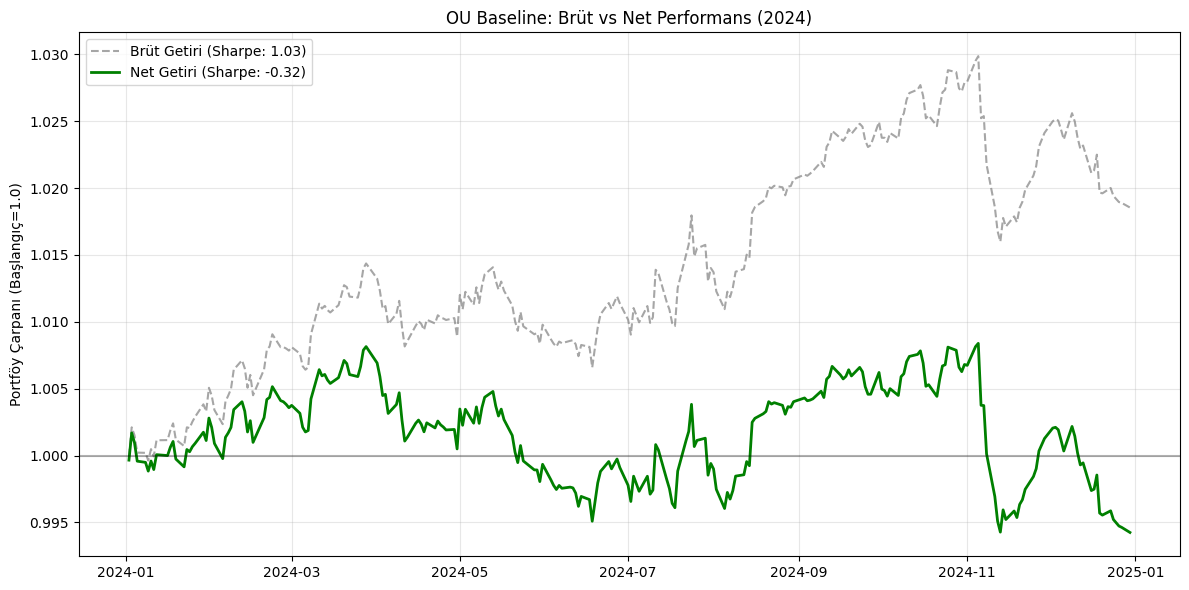

In [10]:
# BU HÜCREYİ "TEST_YEAR = 2024" İLE BAŞLAYAN ANALİZ KISMI YERİNE YAPIŞTIR

# ==========================================================
# DÜZELTİLMİŞ OU BASELINE ANALİZİ (SAFE MODE)
# ==========================================================
TEST_YEAR = 2024
COST_BPS = 0.0005 # 5 baz puan işlem maliyeti
WINDOW_SIZE = 30  # OU pencere boyutu

print("=== OU BASELINE (SAFE MODE) ===")

# 1. Veri Hazırlığı (Buffer ekleyerek)
# Test yılından 'window_size' kadar önceye gidiyoruz ki yılın ilk günü için veri olsun.
buffer_start = pd.to_datetime(f"{TEST_YEAR}-01-01") - pd.offsets.BusinessDay(WINDOW_SIZE + 5)
df_ou_test = residuals_df.loc[buffer_start : f"{TEST_YEAR}-12-31"]

# Yeni "Safe" fonksiyonu çağırıyoruz
X_ou, y_ou, meta_ou = create_ou_sequences_safe(df_ou_test, window_size=WINDOW_SIZE)

# Modeli çalıştır (Tahmin)
# Not: ou_model_predict fonksiyonun önceki hücrelerde tanımlı olmalı
ou_preds, ou_actuals = ou_model_predict(X_ou, y_ou, c_thresh=1.0, c_crit=0.0)

# 2. DataFrame Oluşturma (Veri Kaymasını Önleyen Yöntem)
# Meta listesinden tarih ve hisse sütunlarını ayır
dates_col = [m[0] for m in meta_ou]
tickers_col = [m[1] for m in meta_ou]

df_pnl_ou = pd.DataFrame({
    'Date': dates_col,
    'Ticker': tickers_col,
    'Actual': ou_actuals,
    'Signal': ou_preds.flatten()
})

# Buffer kısmını (önceki yıldan kalan günleri) temizle, sadece 2024 kalsın
df_pnl_ou = df_pnl_ou[df_pnl_ou['Date'].dt.year == TEST_YEAR]
df_pnl_ou = df_pnl_ou.sort_values(['Ticker', 'Date']) # Sıralama önemli!

# 3. İşlem Maliyeti Hesabı (Hisse Bazında Doğru Hesap)
# Önceki günün pozisyonunu al (Ticker bazında shift ederek)
df_pnl_ou['Prev_Signal'] = df_pnl_ou.groupby('Ticker')['Signal'].shift(1).fillna(0)

# Pozisyon değişimi kadar maliyet öde (Al/Sat)
df_pnl_ou['Trade_Cost'] = np.abs(df_pnl_ou['Signal'] - df_pnl_ou['Prev_Signal']) * COST_BPS

# 4. Getiri Hesaplama
df_pnl_ou['Gross_Ret'] = df_pnl_ou['Signal'] * df_pnl_ou['Actual']
df_pnl_ou['Net_Ret'] = df_pnl_ou['Gross_Ret'] - df_pnl_ou['Trade_Cost']

# 5. Portföy Performansı (Eşit Ağırlıklı Ortalaması)
daily_metrics = df_pnl_ou.groupby('Date')[['Gross_Ret', 'Net_Ret']].mean()

daily_gross_ou = daily_metrics['Gross_Ret']
daily_net_ou = daily_metrics['Net_Ret']

print("OU Analizi Tamamlandı. ✅")

# --- RAPORLAMA ---
def calculate_metrics_final(daily_ret, name):
    ann_factor = np.sqrt(252)
    if daily_ret.std() == 0: sharpe = 0
    else: sharpe = (daily_ret.mean() / daily_ret.std()) * ann_factor
    
    total_ret_pct = (np.exp(daily_ret.sum()) - 1) * 100
    vol_pct = (daily_ret.std() * ann_factor) * 100
    
    equity = np.exp(daily_ret.cumsum())
    peak = equity.cummax()
    max_dd = ((equity - peak) / peak * 100).min()
    
    return {
        "Model": name,
        "Sharpe": sharpe,
        "Total Return %": total_ret_pct,
        "Vol %": vol_pct,
        "Max DD %": max_dd
    }

res_df = pd.DataFrame([
    calculate_metrics_final(daily_gross_ou, "OU Baseline (BRÜT)"),
    calculate_metrics_final(daily_net_ou, "OU Baseline (NET)")
])

print("\n" + "="*40)
print(f"   OU BASELINE SONUÇLAR ({TEST_YEAR})")
print("="*40)
print(res_df.set_index("Model"))

# GRAFİK
# Kümülatif Getirileri Hesapla (Log return -> Price series)
equity_gross = np.exp(daily_gross_ou.cumsum())
equity_net   = np.exp(daily_net_ou.cumsum())

plt.figure(figsize=(12, 6))

# 1. Brüt Getiri (Gri, Kesikli Çizgi - Referans)
plt.plot(equity_gross.index, equity_gross.values, 
         label=f"Brüt Getiri (Sharpe: {res_df.iloc[0]['Sharpe']:.2f})", 
         color="gray", linestyle="--", alpha=0.7)

# 2. Net Getiri (Yeşil, Kalın Çizgi - Asıl Sonuç)
plt.plot(equity_net.index, equity_net.values, 
         label=f"Net Getiri (Sharpe: {res_df.iloc[1]['Sharpe']:.2f})", 
         color="green", linewidth=2)

plt.axhline(1.0, color="black", linestyle="-", alpha=0.3)
plt.title(f"OU Baseline: Brüt vs Net Performans ({TEST_YEAR})", fontsize=12)
plt.ylabel("Portföy Çarpanı (Başlangıç=1.0)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

## XGBOOST

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import xgboost as xgb
import optuna
from optuna.integration import XGBoostPruningCallback
import warnings

warnings.filterwarnings("ignore")

# --- YARDIMCI FONKSİYONLAR ---
def calculate_rsi_numpy(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-8)
    return 100 - (100 / (1 + rs))

def prepare_advanced_xgboost_features_aware(residuals_df):
    """
    GELİŞTİRİLMİŞ FEATURE SETİ (TICKER AWARE):
    - Ticker bilgisini sütun olarak saklar.
    - Finansal göstergeleri hesaplar.
    """
    print("Gelişmiş XGBoost Feature Engineering (Ticker Aware) yapılıyor...")
    
    # Kümülatif Fiyatlar (Residuals -> Price Series)
    prices_df = residuals_df.fillna(0.0).cumsum()
    
    features_list = []
    
    # Parametreler
    windows = [10, 30, 60]
    lags = [1, 2, 3, 5, 10, 20, 30]
    
    for ticker in tqdm(residuals_df.columns):
        res_ret = residuals_df[ticker]
        res_price = prices_df[ticker]
        
        df = pd.DataFrame(index=residuals_df.index)
        
        # --- 1. METADATA (KRİTİK ADIM) ---
        df['Ticker'] = ticker  # Ticker ismini saklıyoruz
        
        # --- 2. RETROSPECTIVE FEATURES ---
        for lag in lags:
            df[f'lag_{lag}'] = res_ret.shift(lag)
            
        df['rsi_14'] = calculate_rsi_numpy(res_price, period=14)
        
        for w in windows:
            roll_mean = res_price.rolling(window=w).mean()
            roll_std  = res_price.rolling(window=w).std()
            
            # Z-Score & Volatility
            df[f'zscore_{w}'] = (res_price - roll_mean) / (roll_std + 1e-8)
            df[f'vol_{w}'] = roll_std
            
            # Skewness & Kurtosis (En az 30 gün veri gerekir)
            if w >= 30: 
                df[f'skew_{w}'] = res_price.rolling(window=w).skew()
                df[f'kurt_{w}'] = res_price.rolling(window=w).kurt()
            
            # Bollinger Band Width
            upper = roll_mean + (2 * roll_std)
            lower = roll_mean - (2 * roll_std)
            df[f'bb_width_{w}'] = (upper - lower) / (roll_mean + 1e-8)
            
            # Stochastic Oscillator Logic
            roll_max = res_price.rolling(window=w).max()
            roll_min = res_price.rolling(window=w).min()
            df[f'stoch_{w}'] = (res_price - roll_min) / (roll_max - roll_min + 1e-8)

        # Volatility Ratio
        vol_10 = res_price.rolling(window=10).std()
        vol_60 = res_price.rolling(window=60).std()
        df['vol_ratio'] = vol_10 / (vol_60 + 1e-8)
        
        # --- 3. TARGET ---
        df['target_return'] = res_ret.shift(-1)
        
        df = df.dropna()
        features_list.append(df)
    
    # Listeyi tek DataFrame'e çevir
    full_dataset = pd.concat(features_list)
    
    # Ticker sütunu hariç diğerlerini float32 yaparak bellek tasarrufu yapalım
    cols_to_float = [c for c in full_dataset.columns if c != 'Ticker']
    full_dataset[cols_to_float] = full_dataset[cols_to_float].astype(np.float32)
    
    return full_dataset

# Dataseti Oluştur (residuals_df'in tanımlı olduğu varsayılıyor)
# Eğer residuals_df yoksa önceki adımlardan geldiğini varsayıyorum.
xgb_dataset = prepare_advanced_xgboost_features_aware(residuals_df)

# Feature ve Meta Sütun Ayrımı
meta_cols = ['Ticker', 'target_return']
feature_cols = [c for c in xgb_dataset.columns if c not in meta_cols]

print("\nVeri Seti Hazır!")
print(f"Toplam Veri: {xgb_dataset.shape}")
print(f"Feature Sayısı: {len(feature_cols)}")
print("Örnek Featurelar:", feature_cols[:5])

Gelişmiş XGBoost Feature Engineering (Ticker Aware) yapılıyor...


100%|██████████| 448/448 [00:07<00:00, 59.43it/s]



Veri Seti Hazır!
Toplam Veri: (1541271, 27)
Feature Sayısı: 25
Örnek Featurelar: ['lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10']


In [13]:
# ==========================================================
# 2. OPTUNA HİPERPARAMETRE OPTİMİZASYONU
# ==========================================================

# A. Veri Hazırlığı (Training Havuzu: 2011-2023)
OPT_START_YEAR = 2011
OPT_END_YEAR   = 2023 

print(f"Optimizasyon Dönemi: {OPT_START_YEAR} - {OPT_END_YEAR}")

mask_opt = (xgb_dataset.index.year >= OPT_START_YEAR) & (xgb_dataset.index.year <= OPT_END_YEAR)

# Sadece Feature'ları alıyoruz (Ticker YOK!)
X_opt = xgb_dataset.loc[mask_opt, feature_cols]
y_opt = xgb_dataset.loc[mask_opt, 'target_return']

# B. Expanding Window CV Fonksiyonu
def get_expanding_window_splits(df_index, n_folds=5):
    years = sorted(df_index.year.unique())
    val_years = years[-n_folds:] # Son 5 yıl sırayla validation olur
    
    splits = []
    for v_year in val_years:
        val_mask = (df_index.year == v_year)
        # Train: Validation yılından önceki tüm yıllar
        train_mask = (df_index.year < v_year) & (df_index.year >= years[0])
        
        train_idx = np.where(train_mask)[0]
        val_idx   = np.where(val_mask)[0]
        splits.append((train_idx, val_idx, v_year))
    return splits

splits = get_expanding_window_splits(X_opt.index, n_folds=5)

# C. Objective Function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 250, step=5), # Optimizasyon için sabit, finalde artırılabilir
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 100),
        'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42
    }
    
    threshold = trial.suggest_float('threshold', 0.0001, 0.003, log=True)
    fold_scores = []
    
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    
    for train_idx, val_idx, _ in splits:
        X_tr, X_val = X_opt.iloc[train_idx], X_opt.iloc[val_idx]
        y_tr, y_val = y_opt.iloc[train_idx], y_opt.iloc[val_idx]
        
        model = xgb.XGBRegressor(**params, callbacks=[pruning_callback])
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = model.predict(X_val)
        
        # PnL Simülasyonu
        signals = np.zeros_like(preds)
        signals[preds > threshold] = 1
        signals[preds < -threshold] = -1
        
        # Basit Sharpe (CV sırasında maliyet hesabı yavaşlatır, burada ignore ediyoruz)
        rets = signals * y_val.values
        if np.std(rets) < 1e-9: sharpe = 0
        else: sharpe = np.mean(rets) / np.std(rets) * np.sqrt(252)
        
        # Az işlem cezası
        n_trades = np.sum(signals != 0)
        if n_trades < 50: sharpe *= (n_trades / 50.0)
            
        fold_scores.append(sharpe)
    
    return np.mean(fold_scores)

print("Optimizasyon Başlıyor...")
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=100)

print(f"\nEn İyi Sharpe: {study.best_value:.4f}")
best_params = study.best_params
BEST_THRESHOLD = best_params.pop('threshold')
print(f"En İyi Threshold: {BEST_THRESHOLD}")
best_params
print(best_params)

Optimizasyon Dönemi: 2011 - 2023


[I 2026-01-03 21:06:17,049] A new study created in memory with name: no-name-d26829e4-1df6-44d7-b3f6-741b9373d863


Optimizasyon Başlıyor...


[I 2026-01-03 21:06:23,918] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 165, 'learning_rate': 0.0367087583883699, 'max_depth': 5, 'min_child_weight': 45, 'gamma': 0.34094783869326645, 'subsample': 0.8816999292617738, 'colsample_bytree': 0.8964355921294079, 'reg_alpha': 0.15273416829878958, 'reg_lambda': 0.03340598724526315, 'threshold': 0.0008981513501480069}. Best is trial 0 with value: 0.0.
[I 2026-01-03 21:06:31,715] Trial 1 finished with value: 0.1483227378599341 and parameters: {'n_estimators': 110, 'learning_rate': 0.05108232870605458, 'max_depth': 5, 'min_child_weight': 11, 'gamma': 0.0006827274544663475, 'subsample': 0.670135470604571, 'colsample_bytree': 0.8447812881772344, 'reg_alpha': 0.03210094125778778, 'reg_lambda': 1.095232697215089, 'threshold': 0.0002105127687104463}. Best is trial 1 with value: 0.1483227378599341.
[I 2026-01-03 21:06:37,759] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 135, 'learning_rate': 0.0110335987679764


En İyi Sharpe: 0.1651
En İyi Threshold: 0.00016562813537743793
{'n_estimators': 155, 'learning_rate': 0.09981568267839597, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 0.0023667079346329292, 'subsample': 0.6473525906838005, 'colsample_bytree': 0.8216451620629818, 'reg_alpha': 0.030054041913157494, 'reg_lambda': 1.6003025939479294}


Eğitim Seti Boyutu: (1429271, 25)
Test Seti Boyutu  : (112000, 25)

Final Model Eğitiliyor...

   XGBOOST FINAL PERFORMANS (2024)
Toplam İşlem     : 19420
Win Rate         : %50.79
--------------------------------------------------
Metrik          Brüt            Net            
--------------------------------------------------
Sharpe Ratio    2.4366          0.9073
Total Return %  3.54           1.30
Max Drawdown %  -0.69           -1.05


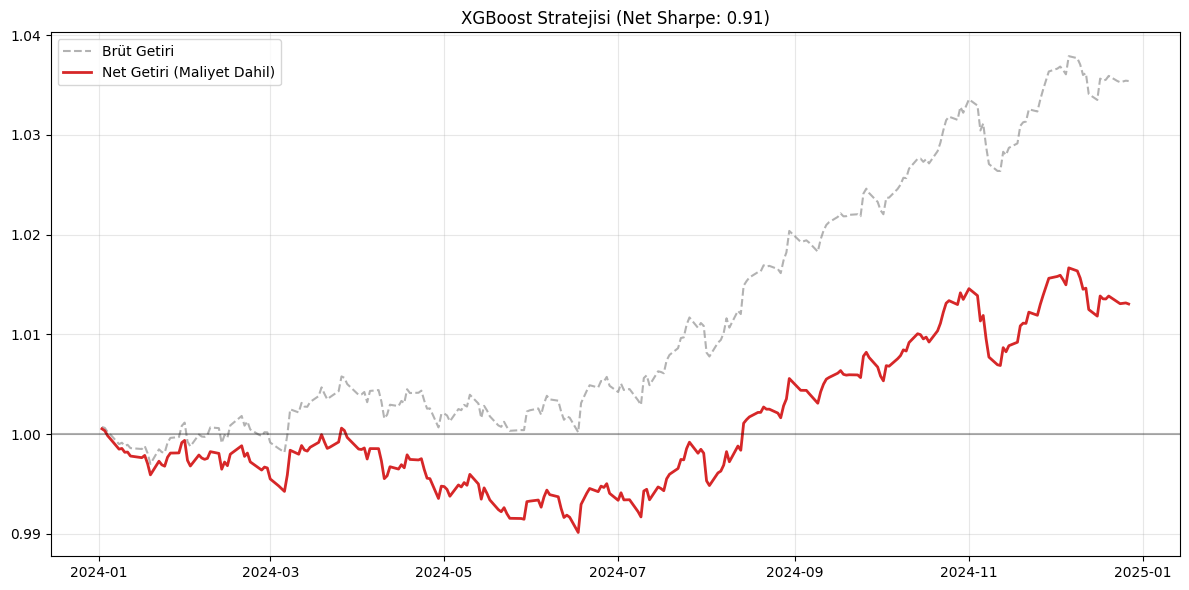

In [14]:
# ==========================================================
# 3. FINAL MODEL VE TICKER AWARE BACKTEST (DÜZELTİLMİŞ)
# ==========================================================
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

TEST_YEAR = 2024
COST_BPS = 0.0005 # 5 Baz Puan Komisyon

# A. Veri Ayrımı
# Train: 2011'den 2024 başına kadar
train_mask = (xgb_dataset.index.year >= 2011) & (xgb_dataset.index.year < TEST_YEAR)
# Test: Sadece 2024
test_mask = (xgb_dataset.index.year == TEST_YEAR)

# Eğitim için sadece Featurelar
X_train = xgb_dataset.loc[train_mask, feature_cols]
y_train = xgb_dataset.loc[train_mask, 'target_return']

# Test için Featurelar + Metadata (Ticker)
X_test = xgb_dataset.loc[test_mask, feature_cols]
# Meta_test: Backtest dataframe'i oluşturmak için kritik
meta_test = xgb_dataset.loc[test_mask, ['Ticker', 'target_return']] 

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu  : {X_test.shape}")

# B. Model Eğitimi (Full Train)
best_params = {
    'n_estimators': 140,
    'learning_rate': 0.005758627734727662,
    'max_depth': 9,
    'min_child_weight': 47,
    'gamma': 0.00012889309702728672,
    'subsample': 0.8630329743440232,
    'colsample_bytree': 0.62528995188944,
    'reg_alpha': 3.8668313133327072,
    'reg_lambda': 2.4591429950315464,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42
}
BEST_THRESHOLD = 0.00010703504447178335

print("\nFinal Model Eğitiliyor...")
#final_model = xgb.XGBRegressor(**best_params, n_jobs=-1, random_state=42)
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train, verbose=False)

# C. Tahmin
preds = final_model.predict(X_test)

# D. TICKER AWARE BACKTEST (BÜYÜK RESİM)
# --- HATA DÜZELTME BURADA YAPILDI ---
# .values kullanarak index çakışmasını engelliyoruz.
df_res = pd.DataFrame({
    'Date': X_test.index,
    'Ticker': meta_test['Ticker'].values,         # .values eklendi
    'Actual_Return': meta_test['target_return'].values, # .values eklendi
    'Pred_Score': preds
})

# Sinyaller
df_res['Signal'] = 0
df_res.loc[df_res['Pred_Score'] > BEST_THRESHOLD, 'Signal'] = 1
df_res.loc[df_res['Pred_Score'] < -BEST_THRESHOLD, 'Signal'] = -1

# --- DOĞRU MALİYET HESABI ---
# Ticker'a göre gruplayıp kaydırma yapıyoruz. 
# Böylece Apple'ın sinyali Microsoft ile karışmıyor.
df_res['Prev_Signal'] = df_res.groupby('Ticker')['Signal'].shift(1).fillna(0)

# Pozisyon Değişimi (Al/Sat/Kapat)
df_res['Trade_Cost'] = np.abs(df_res['Signal'] - df_res['Prev_Signal']) * COST_BPS

# Getiriler
df_res['Gross_Ret'] = df_res['Signal'] * df_res['Actual_Return']
df_res['Net_Ret'] = df_res['Gross_Ret'] - df_res['Trade_Cost']

# E. Portföy Performansı (Günlük Ortalama)
# Artık index çakışması olmadığı için bu satır hata vermeyecek
portfolio_daily = df_res.groupby('Date')[['Gross_Ret', 'Net_Ret']].mean()

# --- RAPORLAMA ---
def get_stats(daily_ret):
    ann_factor = np.sqrt(252)
    # Sıfıra bölünme hatası önlemi
    std = daily_ret.std()
    if std == 0 or np.isnan(std): 
        sharpe = 0
    else: 
        sharpe = (daily_ret.mean() / std) * ann_factor
        
    total_ret_pct = (np.exp(daily_ret.sum()) - 1) * 100
    
    equity = np.exp(daily_ret.cumsum())
    peak = equity.cummax()
    # Drawdown hesaplarken peak 0 olabilir mi? Hayır equity hep pozitiftir ama yine de check
    with np.errstate(divide='ignore', invalid='ignore'):
        dd = (equity - peak) / peak
        max_dd = dd.min() * 100
    
    return sharpe, total_ret_pct, max_dd

sh_gr, ret_gr, dd_gr = get_stats(portfolio_daily['Gross_Ret'])
sh_net, ret_net, dd_net = get_stats(portfolio_daily['Net_Ret'])

# İşlem İstatistikleri
total_trades = (df_res['Signal'] != df_res['Prev_Signal']).sum()
win_rate = 0.0
winning_trades = df_res[(df_res['Signal'] != 0) & (df_res['Gross_Ret'] > 0)]
total_signals = df_res[df_res['Signal'] != 0].shape[0]

if total_signals > 0:
    win_rate = (len(winning_trades) / total_signals) * 100

print("\n" + "="*50)
print(f"   XGBOOST FINAL PERFORMANS ({TEST_YEAR})")
print("="*50)
print(f"Toplam İşlem     : {total_trades}")
print(f"Win Rate         : %{win_rate:.2f}")
print("-" * 50)
print(f"{'Metrik':<15} {'Brüt':<15} {'Net':<15}")
print("-" * 50)
print(f"{'Sharpe Ratio':<15} {sh_gr:.4f}          {sh_net:.4f}")
print(f"{'Total Return %':<15} {ret_gr:.2f}           {ret_net:.2f}")
print(f"{'Max Drawdown %':<15} {dd_gr:.2f}           {dd_net:.2f}")
print("="*50)

# --- GRAFİK ---
equity_gross = np.exp(portfolio_daily['Gross_Ret'].cumsum())
equity_net = np.exp(portfolio_daily['Net_Ret'].cumsum())

plt.figure(figsize=(12, 6))
plt.plot(equity_gross.index, equity_gross.values, label='Brüt Getiri', color='gray', linestyle='--', alpha=0.6)
plt.plot(equity_net.index, equity_net.values, label='Net Getiri (Maliyet Dahil)', color='#d62728', linewidth=2)
plt.axhline(1.0, color='black', alpha=0.3)
plt.title(f"XGBoost Stratejisi (Net Sharpe: {sh_net:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()

## CNN

Epoch 01 | Train MSE 0.001282 | Pred μ -0.00008 σ 0.01100 | Val Sharpe (2023) -0.046
Epoch 02 | Train MSE 0.000213 | Pred μ -0.00001 σ 0.00272 | Val Sharpe (2023) +0.046
Epoch 03 | Train MSE 0.000205 | Pred μ +0.00001 σ 0.00108 | Val Sharpe (2023) -0.046
Epoch 04 | Train MSE 0.000203 | Pred μ +0.00002 σ 0.00034 | Val Sharpe (2023) -0.047
Epoch 05 | Train MSE 0.000202 | Pred μ +0.00001 σ 0.00026 | Val Sharpe (2023) +0.044
Epoch 06 | Train MSE 0.000203 | Pred μ +0.00002 σ 0.00028 | Val Sharpe (2023) -0.046
Epoch 07 | Train MSE 0.000202 | Pred μ +0.00001 σ 0.00028 | Val Sharpe (2023) +0.046
Epoch 08 | Train MSE 0.000202 | Pred μ +0.00002 σ 0.00021 | Val Sharpe (2023) -0.046
Epoch 09 | Train MSE 0.000202 | Pred μ +0.00001 σ 0.00019 | Val Sharpe (2023) -0.046
Epoch 10 | Train MSE 0.000202 | Pred μ +0.00002 σ 0.00018 | Val Sharpe (2023) -0.046

>>> Best validation Sharpe (2023): +0.046

   CNN + TRANSFORMER FINAL PERFORMANS (2024)
Toplam İşlem     : 448
Win Rate         : %50.36
------------

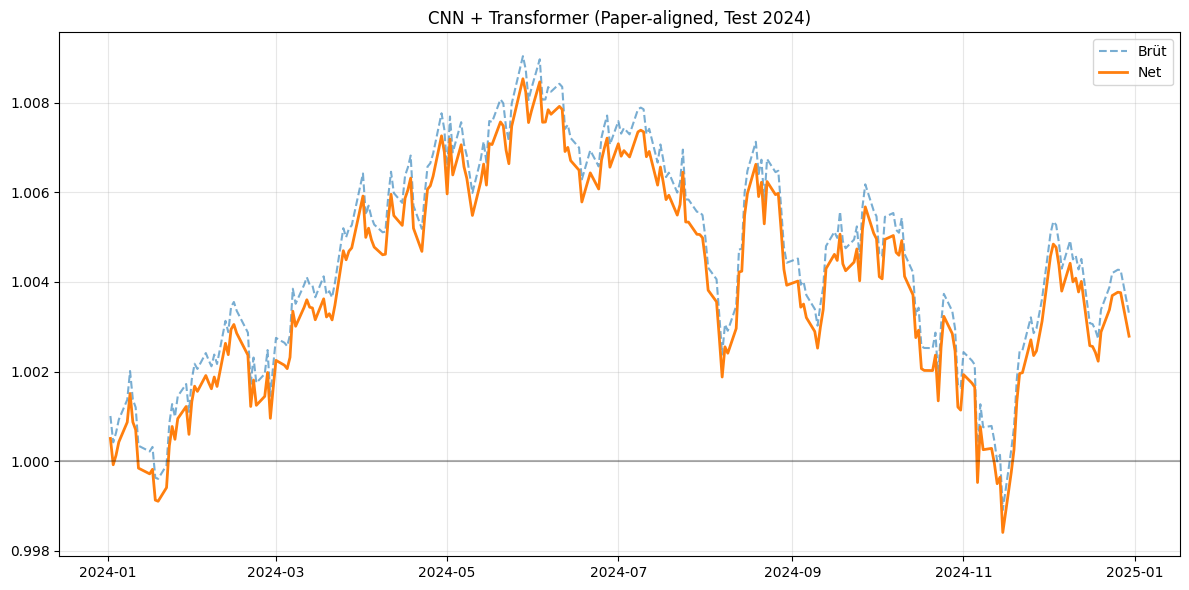

In [38]:
# ==========================================================
# CNN + TRANSFORMER (PAPER-ALIGNED, END-TO-END BENCHMARK)
# Leakage-free: Train <2023 | Val 2023 | Test 2024
# Input = Rolling Cumulative Residual State (Paper-aligned)
# ==========================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==========================================================
# 1. CONFIG
# ==========================================================
WINDOW_SIZE   = 30
VAL_YEAR     = 2023
TEST_YEAR    = 2024
COST_BPS     = 0.0005
DL_THRESHOLD = 0.0001

EPOCHS = 10
BATCH  = 256
LR     = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# ==========================================================
# 2. PAPER-ALIGNED INPUT CONSTRUCTION
# residual -> rolling cumulative state
# ==========================================================
def create_cumulative_sequences(residuals_df, window):
    X, y, meta = [], [], []

    for ticker in residuals_df.columns:
        s = residuals_df[ticker].dropna()

        for t in range(window, len(s) - 1):
            seq = np.cumsum(s.values[t-window:t])   # <<< PAPER STEP
            X.append(seq)
            y.append(s.values[t + 1])               # next-day residual
            meta.append((s.index[t + 1], ticker))

    return np.array(X), np.array(y), meta


X_all, y_all, meta_all = create_cumulative_sequences(
    residuals_df,
    WINDOW_SIZE
)

dates = pd.to_datetime([m[0] for m in meta_all])
years = dates.year.values

train_idx = np.where(years < VAL_YEAR)[0]
val_idx   = np.where(years == VAL_YEAR)[0]
test_idx  = np.where(years == TEST_YEAR)[0]

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_val,   y_val   = X_all[val_idx],   y_all[val_idx]
X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

meta_test = [meta_all[i] for i in test_idx]

# ==========================================================
# 3. TORCH DATASET
# ==========================================================
class ResidualSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ==========================================================
# 4. MODEL (CNN + Transformer, no-PE baseline)
# ==========================================================
class CNNTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.proj = nn.Linear(32, 64)

        enc = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=4,
            dim_feedforward=128,
            dropout=0.1,
            batch_first=True,
            norm_first=True
        )

        self.tr = nn.TransformerEncoder(enc, num_layers=2)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)   # (B,1,L)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)   # (B,L,32)
        x = self.proj(x)
        x = self.tr(x)
        return self.fc(x[:, -1]).squeeze(-1)

# ==========================================================
# 5. TRAINING (Val = 2023, Sharpe-based, anti-collapse)
# ==========================================================
model = CNNTransformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

train_loader = DataLoader(
    ResidualSequenceDataset(X_train, y_train),
    batch_size=BATCH,
    shuffle=True
)

val_loader = DataLoader(
    ResidualSequenceDataset(X_val, y_val),
    batch_size=512
)

best_sharpe = -np.inf
best_state  = None

for epoch in range(EPOCHS):

    # ---- TRAIN ----
    model.train()
    losses, mus, stds = [], [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)

        mse = F.mse_loss(preds, yb)
        var = torch.var(preds)
        loss = mse - 1e-3 * var   # anti-collapse

        loss.backward()
        optimizer.step()

        losses.append(mse.item())
        mus.append(preds.mean().item())
        stds.append(preds.std().item())

    # ---- VALIDATION (2023) ----
    model.eval()
    preds_all, y_all = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds_all.append(model(xb).cpu().numpy())
            y_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all)
    y_all     = np.concatenate(y_all)

    sig = np.where(preds_all >  DL_THRESHOLD,  1,
          np.where(preds_all < -DL_THRESHOLD, -1, 0))

    rets = sig * y_all
    sharpe = (
        np.mean(rets) / np.std(rets) * np.sqrt(252)
        if np.std(rets) > 0 else 0.0
    )

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train MSE {np.mean(losses):.6f} | "
        f"Pred μ {np.mean(mus):+.5f} σ {np.mean(stds):.5f} | "
        f"Val Sharpe (2023) {sharpe:+.3f}"
    )

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_state = {k: v.detach().cpu().clone()
                      for k, v in model.state_dict().items()}

# ==========================================================
# 6. LOAD BEST MODEL & TEST INFERENCE (2024)
# ==========================================================
model.load_state_dict(best_state)
model.to(device)
model.eval()

print(f"\n>>> Best validation Sharpe (2023): {best_sharpe:+.3f}")

with torch.no_grad():
    preds = model(
        torch.tensor(X_test, dtype=torch.float32)
        .unsqueeze(-1)
        .to(device)
    ).cpu().numpy()

# ==========================================================
# 7. TICKER-AWARE BACKTEST (XGB FORMAT)
# ==========================================================
df = pd.DataFrame({
    "Date":   [m[0] for m in meta_test],
    "Ticker": [m[1] for m in meta_test],
    "Actual": y_test,
    "Pred":   preds
})

df["Signal"] = 0
df.loc[df.Pred >  DL_THRESHOLD, "Signal"] = 1
df.loc[df.Pred < -DL_THRESHOLD, "Signal"] = -1
df["Signal"] = df["Signal"].astype(int)

df["Prev_Signal"] = (
    df.groupby("Ticker")["Signal"].shift(1).fillna(0).astype(int)
)

df["Turnover"] = np.abs(df.Signal - df.Prev_Signal)
df["Cost"]     = df.Turnover * COST_BPS

df["Gross_Ret"] = df.Signal * df.Actual
df["Net_Ret"]   = df.Gross_Ret - df.Cost

portfolio = df.groupby("Date")[["Gross_Ret", "Net_Ret"]].mean()

# ==========================================================
# 8. METRICS + REPORT (XGB STYLE)
# ==========================================================
def compute_stats(ret):
    ann = np.sqrt(252)
    std = ret.std()
    sharpe = (ret.mean() / std) * ann if std > 0 else 0.0
    total = (np.exp(ret.sum()) - 1) * 100
    equity = np.exp(ret.cumsum())
    dd = ((equity - equity.cummax()) / equity.cummax()).min() * 100
    return sharpe, total, dd, equity

sh_g, ret_g, dd_g, eq_g = compute_stats(portfolio["Gross_Ret"])
sh_n, ret_n, dd_n, eq_n = compute_stats(portfolio["Net_Ret"])

total_trades = (df.Signal != df.Prev_Signal).sum()
wins = df[(df.Signal != 0) & (df.Gross_Ret > 0)]
total_signals = (df.Signal != 0).sum()
win_rate = (len(wins) / total_signals * 100) if total_signals > 0 else 0.0

print("\n" + "="*50)
print(f"   CNN + TRANSFORMER FINAL PERFORMANS ({TEST_YEAR})")
print("="*50)
print(f"Toplam İşlem     : {total_trades}")
print(f"Win Rate         : %{win_rate:.2f}")
print("-" * 50)
print(f"{'Metrik':<15} {'Brüt':<15} {'Net':<15}")
print("-" * 50)
print(f"{'Sharpe Ratio':<15} {sh_g:.4f}          {sh_n:.4f}")
print(f"{'Total Return %':<15} {ret_g:.2f}           {ret_n:.2f}")
print(f"{'Max Drawdown %':<15} {dd_g:.2f}           {dd_n:.2f}")
print("="*50)

# ==========================================================
# 9. EQUITY CURVE
# ==========================================================
plt.figure(figsize=(12,6))
plt.plot(eq_g.index, eq_g.values, "--", label="Brüt", alpha=0.6)
plt.plot(eq_n.index, eq_n.values, label="Net", linewidth=2)
plt.axhline(1.0, color="black", alpha=0.3)
plt.title(f"CNN + Transformer (Paper-aligned, Test {TEST_YEAR})")
plt.legend()
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()


OU Veri Seti (Safe) oluşturuluyor... (Hisse: 448)


100%|██████████| 448/448 [00:07<00:00, 56.06it/s]


Epoch 01 | Train MSE 0.001272 | Pred μ -0.00008 σ 0.01094 | Val Sharpe (2023) -0.034
Epoch 02 | Train MSE 0.000212 | Pred μ -0.00001 σ 0.00273 | Val Sharpe (2023) -0.046
Epoch 03 | Train MSE 0.000203 | Pred μ +0.00001 σ 0.00107 | Val Sharpe (2023) -0.015
Epoch 04 | Train MSE 0.000201 | Pred μ +0.00001 σ 0.00037 | Val Sharpe (2023) +0.046
Epoch 05 | Train MSE 0.000202 | Pred μ +0.00001 σ 0.00033 | Val Sharpe (2023) +0.046
Epoch 06 | Train MSE 0.000201 | Pred μ +0.00001 σ 0.00027 | Val Sharpe (2023) +0.046
Epoch 07 | Train MSE 0.000201 | Pred μ +0.00002 σ 0.00027 | Val Sharpe (2023) -0.027
Epoch 08 | Train MSE 0.000201 | Pred μ +0.00001 σ 0.00022 | Val Sharpe (2023) +0.066
Epoch 09 | Train MSE 0.000202 | Pred μ +0.00001 σ 0.00029 | Val Sharpe (2023) +0.136
Epoch 10 | Train MSE 0.000201 | Pred μ +0.00002 σ 0.00026 | Val Sharpe (2023) -0.008

>>> Best validation Sharpe (2023): +0.136

   CNN + TRANSFORMER FINAL PERFORMANS (2024)
Toplam İşlem     : 2921
Win Rate         : %50.47
-----------

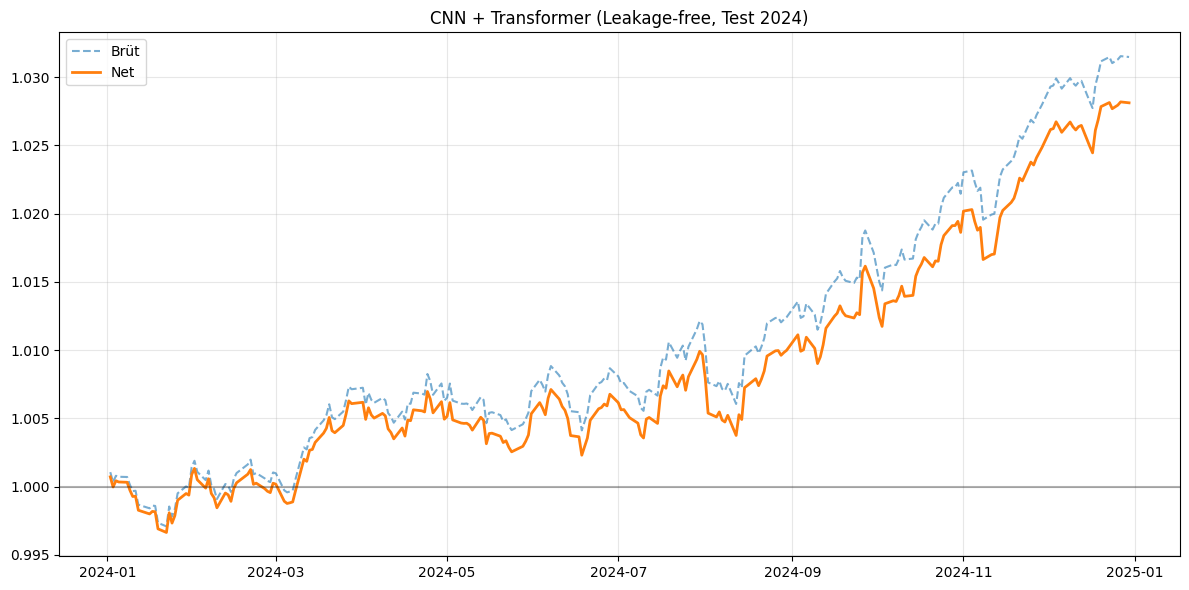

In [ ]:
# ==========================================================
# CNN + TRANSFORMER (END-TO-END DEEP LEARNING BENCHMARK)
# Leakage-free: Train <2023 | Val 2023 | Test 2024
# ==========================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------------------------------------
# 1. CONFIG
# ----------------------------------------------------------
WINDOW_SIZE  = 30
VAL_YEAR    = 2023
TEST_YEAR   = 2024
COST_BPS    = 0.0005
DL_THRESHOLD = 0.0001

EPOCHS = 10
BATCH  = 256
LR     = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# ----------------------------------------------------------
# 2. DATASET (OU SAFE SEQUENCES)
# ----------------------------------------------------------
X_all, y_all, meta_all = create_ou_sequences_safe(
    residuals_df,
    window_size=WINDOW_SIZE
)

dates = pd.to_datetime([m[0] for m in meta_all])
years = dates.year.values

train_idx = np.where(years < VAL_YEAR)[0]
val_idx   = np.where(years == VAL_YEAR)[0]
test_idx  = np.where(years == TEST_YEAR)[0]

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_val,   y_val   = X_all[val_idx],   y_all[val_idx]
X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

meta_test = [meta_all[i] for i in test_idx]

# ----------------------------------------------------------
# 3. TORCH DATASET
# ----------------------------------------------------------
class ResidualSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----------------------------------------------------------
# 4. MODEL
# ----------------------------------------------------------
class CNNTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.proj = nn.Linear(32, 64)

        enc = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=4,
            dim_feedforward=128,
            dropout=0.1,
            batch_first=True,
            norm_first=True
        )

        self.tr = nn.TransformerEncoder(enc, num_layers=2)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x = self.proj(x)
        x = self.tr(x)
        return self.fc(x[:, -1]).squeeze(-1)

# ----------------------------------------------------------
# 5. TRAINING (Val = 2023, Sharpe-based selection)
# ----------------------------------------------------------
model = CNNTransformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

train_loader = DataLoader(
    ResidualSequenceDataset(X_train, y_train),
    batch_size=BATCH,
    shuffle=True
)

val_loader = DataLoader(
    ResidualSequenceDataset(X_val, y_val),
    batch_size=512
)

best_sharpe = -np.inf
best_state  = None

for epoch in range(EPOCHS):

    # ---- TRAIN ----
    model.train()
    losses, mus, stds = [], [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)

        mse = F.mse_loss(preds, yb)
        var = torch.var(preds)
        loss = mse - 1e-3 * var   # anti-collapse

        loss.backward()
        optimizer.step()

        losses.append(mse.item())
        mus.append(preds.mean().item())
        stds.append(preds.std().item())

    # ---- VALIDATION (2023) ----
    model.eval()
    preds_all, y_all = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds_all.append(model(xb).cpu().numpy())
            y_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all)
    y_all     = np.concatenate(y_all)

    sig = np.where(preds_all >  DL_THRESHOLD,  1,
          np.where(preds_all < -DL_THRESHOLD, -1, 0))

    rets = sig * y_all
    sharpe = (
        np.mean(rets) / np.std(rets) * np.sqrt(252)
        if np.std(rets) > 0 else 0.0
    )

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train MSE {np.mean(losses):.6f} | "
        f"Pred μ {np.mean(mus):+.5f} σ {np.mean(stds):.5f} | "
        f"Val Sharpe (2023) {sharpe:+.3f}"
    )

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_state = {k: v.detach().cpu().clone()
                      for k, v in model.state_dict().items()}

# ----------------------------------------------------------
# LOAD BEST MODEL
# ----------------------------------------------------------
model.load_state_dict(best_state)
model.to(device)
model.eval()

print(f"\n>>> Best validation Sharpe (2023): {best_sharpe:+.3f}")

# ----------------------------------------------------------
# 6. INFERENCE (TEST YEAR = 2024)
# ----------------------------------------------------------
with torch.no_grad():
    preds = model(
        torch.tensor(X_test, dtype=torch.float32)
        .unsqueeze(-1)
        .to(device)
    ).cpu().numpy()

# ----------------------------------------------------------
# 7. TICKER-AWARE BACKTEST
# ----------------------------------------------------------
df_res = pd.DataFrame({
    "Date":   [m[0] for m in meta_test],
    "Ticker": [m[1] for m in meta_test],
    "Actual": y_test,
    "Pred":   preds
})

df_res["Signal"] = 0
df_res.loc[df_res.Pred >  DL_THRESHOLD, "Signal"] = 1
df_res.loc[df_res.Pred < -DL_THRESHOLD, "Signal"] = -1
df_res["Signal"] = df_res["Signal"].astype(int)

df_res["Prev_Signal"] = (
    df_res.groupby("Ticker")["Signal"]
          .shift(1)
          .fillna(0)
          .astype(int)
)

df_res["Turnover"] = np.abs(df_res.Signal - df_res.Prev_Signal)
df_res["Cost"]     = df_res.Turnover * COST_BPS

df_res["Gross_Ret"] = df_res.Signal * df_res.Actual
df_res["Net_Ret"]   = df_res.Gross_Ret - df_res.Cost

portfolio_daily = (
    df_res.groupby("Date")[["Gross_Ret", "Net_Ret"]].mean()
)

# ----------------------------------------------------------
# 8. METRICS + REPORT (XGB FORMAT)
# ----------------------------------------------------------
def compute_stats(ret):
    ann = np.sqrt(252)
    std = ret.std()
    sharpe = (ret.mean() / std) * ann if std > 0 else 0.0
    total_ret = (np.exp(ret.sum()) - 1) * 100
    equity = np.exp(ret.cumsum())
    max_dd = ((equity - equity.cummax()) / equity.cummax()).min() * 100
    return sharpe, total_ret, max_dd, equity

sh_gr, ret_gr, dd_gr, eq_gr = compute_stats(portfolio_daily["Gross_Ret"])
sh_net, ret_net, dd_net, eq_net = compute_stats(portfolio_daily["Net_Ret"])

total_trades = (df_res.Signal != df_res.Prev_Signal).sum()
wins = df_res[(df_res.Signal != 0) & (df_res.Gross_Ret > 0)]
total_signals = (df_res.Signal != 0).sum()
win_rate = (len(wins) / total_signals * 100) if total_signals > 0 else 0.0

print("\n" + "="*50)
print(f"   CNN + TRANSFORMER FINAL PERFORMANS ({TEST_YEAR})")
print("="*50)
print(f"Toplam İşlem     : {total_trades}")
print(f"Win Rate         : %{win_rate:.2f}")
print("-" * 50)
print(f"{'Metrik':<15} {'Brüt':<15} {'Net':<15}")
print("-" * 50)
print(f"{'Sharpe Ratio':<15} {sh_gr:.4f}          {sh_net:.4f}")
print(f"{'Total Return %':<15} {ret_gr:.2f}           {ret_net:.2f}")
print(f"{'Max Drawdown %':<15} {dd_gr:.2f}           {dd_net:.2f}")
print("="*50)

# ----------------------------------------------------------
# 9. EQUITY CURVE
# ----------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(eq_gr.index, eq_gr.values, "--", label="Brüt", alpha=0.6)
plt.plot(eq_net.index, eq_net.values, label="Net", linewidth=2)
plt.axhline(1.0, color="black", alpha=0.3)
plt.title(f"CNN + Transformer (Leakage-free, Test {TEST_YEAR})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()


In [ ]:
# ==========================================================
# WINDOW-BASED NORMALIZATION
# Z-score veya Min-Max normalizasyonu
# ==========================================================

def normalize_sequences_window(X, method='zscore'):
    """
    Her window için ayrı ayrı normalizasyon yapar.
    
    Parameters:
    -----------
    X : np.array
        Shape: (n_samples, window_size)
    method : str
        'zscore' veya 'minmax'
    
    Returns:
    --------
    X_norm : np.array
        Normalize edilmiş sequences
    """
    X_norm = X.copy()
    
    if method == 'zscore':
        # Z-score normalization: (x - mean) / std
        for i in range(len(X)):
            seq = X[i]
            mean = np.mean(seq)
            std = np.std(seq)
            if std > 1e-8:  # Avoid division by zero
                X_norm[i] = (seq - mean) / std
            else:
                X_norm[i] = seq - mean  # If std is too small, just center
    
    elif method == 'minmax':
        # Min-Max normalization: (x - min) / (max - min)
        for i in range(len(X)):
            seq = X[i]
            min_val = np.min(seq)
            max_val = np.max(seq)
            if max_val - min_val > 1e-8:  # Avoid division by zero
                X_norm[i] = (seq - min_val) / (max_val - min_val)
            else:
                X_norm[i] = np.zeros_like(seq)  # If all values are same, set to 0
    
    else:
        raise ValueError(f"Unknown normalization method: {method}")
    
    return X_norm


# ==========================================================
# CNN + TRANSFORMER (END-TO-END DEEP LEARNING BENCHMARK)
# Leakage-free: Train <2023 | Val 2023 | Test 2024
# ==========================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------------------------------------
# 1. CONFIG
# ----------------------------------------------------------
WINDOW_SIZE  = 30
VAL_YEAR    = 2023
TEST_YEAR   = 2024
COST_BPS    = 0.0005
DL_THRESHOLD = 0.0001

EPOCHS = 10
BATCH  = 256
LR     = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# ----------------------------------------------------------
# 2. DATASET (OU SAFE SEQUENCES)
# ----------------------------------------------------------
X_all, y_all, meta_all = create_ou_sequences_safe(
    residuals_df,
    window_size=WINDOW_SIZE
)

dates = pd.to_datetime([m[0] for m in meta_all])
years = dates.year.values

train_idx = np.where(years < VAL_YEAR)[0]
val_idx   = np.where(years == VAL_YEAR)[0]
test_idx  = np.where(years == TEST_YEAR)[0]

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_val,   y_val   = X_all[val_idx],   y_all[val_idx]
X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

meta_test = [meta_all[i] for i in test_idx]

# ----------------------------------------------------------
# 2.5. WINDOW-BASED NORMALIZATION
# ----------------------------------------------------------
# Normalize each window independently using z-score
X_train = normalize_sequences_window(X_train, method='zscore')
X_val   = normalize_sequences_window(X_val, method='zscore')
X_test  = normalize_sequences_window(X_test, method='zscore')

# ----------------------------------------------------------
# 3. TORCH DATASET
# ----------------------------------------------------------
class ResidualSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----------------------------------------------------------
# 4. MODEL
# ----------------------------------------------------------
class CNNTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, padding=1),
            nn.ReLU()
        )

        self.proj = nn.Linear(32, 64)

        enc = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=4,
            dim_feedforward=128,
            dropout=0.1,
            batch_first=True,
            norm_first=True
        )

        self.tr = nn.TransformerEncoder(enc, num_layers=2)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x = self.proj(x)
        x = self.tr(x)
        return self.fc(x[:, -1]).squeeze(-1)

# ----------------------------------------------------------
# 5. TRAINING (Val = 2023, Sharpe-based selection)
# ----------------------------------------------------------
model = CNNTransformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

train_loader = DataLoader(
    ResidualSequenceDataset(X_train, y_train),
    batch_size=BATCH,
    shuffle=True
)

val_loader = DataLoader(
    ResidualSequenceDataset(X_val, y_val),
    batch_size=512
)

best_sharpe = -np.inf
best_state  = None

for epoch in range(EPOCHS):

    # ---- TRAIN ----
    model.train()
    losses, mus, stds = [], [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)

        mse = F.mse_loss(preds, yb)
        var = torch.var(preds)
        loss = mse - 1e-3 * var   # anti-collapse

        loss.backward()
        optimizer.step()

        losses.append(mse.item())
        mus.append(preds.mean().item())
        stds.append(preds.std().item())

    # ---- VALIDATION (2023) ----
    model.eval()
    preds_all, y_all = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds_all.append(model(xb).cpu().numpy())
            y_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all)
    y_all     = np.concatenate(y_all)

    sig = np.where(preds_all >  DL_THRESHOLD,  1,
          np.where(preds_all < -DL_THRESHOLD, -1, 0))

    rets = sig * y_all
    sharpe = (
        np.mean(rets) / np.std(rets) * np.sqrt(252)
        if np.std(rets) > 0 else 0.0
    )

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train MSE {np.mean(losses):.6f} | "
        f"Pred μ {np.mean(mus):+.5f} σ {np.mean(stds):.5f} | "
        f"Val Sharpe (2023) {sharpe:+.3f}"
    )

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_state = {k: v.detach().cpu().clone()
                      for k, v in model.state_dict().items()}

# ----------------------------------------------------------
# LOAD BEST MODEL
# ----------------------------------------------------------
model.load_state_dict(best_state)
model.to(device)
model.eval()

print(f"\n>>> Best validation Sharpe (2023): {best_sharpe:+.3f}")

# ----------------------------------------------------------
# 6. INFERENCE (TEST YEAR = 2024)
# ----------------------------------------------------------
with torch.no_grad():
    preds = model(
        torch.tensor(X_test, dtype=torch.float32)
        .unsqueeze(-1)
        .to(device)
    ).cpu().numpy()

# ----------------------------------------------------------
# 7. TICKER-AWARE BACKTEST
# ----------------------------------------------------------
df_res = pd.DataFrame({
    "Date":   [m[0] for m in meta_test],
    "Ticker": [m[1] for m in meta_test],
    "Actual": y_test,
    "Pred":   preds
})

df_res["Signal"] = 0
df_res.loc[df_res.Pred >  DL_THRESHOLD, "Signal"] = 1
df_res.loc[df_res.Pred < -DL_THRESHOLD, "Signal"] = -1
df_res["Signal"] = df_res["Signal"].astype(int)

df_res["Prev_Signal"] = (
    df_res.groupby("Ticker")["Signal"]
          .shift(1)
          .fillna(0)
          .astype(int)
)

df_res["Turnover"] = np.abs(df_res.Signal - df_res.Prev_Signal)
df_res["Cost"]     = df_res.Turnover * COST_BPS

df_res["Gross_Ret"] = df_res.Signal * df_res.Actual
df_res["Net_Ret"]   = df_res.Gross_Ret - df_res.Cost

portfolio_daily = (
    df_res.groupby("Date")[["Gross_Ret", "Net_Ret"]].mean()
)

# ----------------------------------------------------------
# 8. METRICS + REPORT (XGB FORMAT)
# ----------------------------------------------------------
def compute_stats(ret):
    ann = np.sqrt(252)
    std = ret.std()
    sharpe = (ret.mean() / std) * ann if std > 0 else 0.0
    total_ret = (np.exp(ret.sum()) - 1) * 100
    equity = np.exp(ret.cumsum())
    max_dd = ((equity - equity.cummax()) / equity.cummax()).min() * 100
    return sharpe, total_ret, max_dd, equity

sh_gr, ret_gr, dd_gr, eq_gr = compute_stats(portfolio_daily["Gross_Ret"])
sh_net, ret_net, dd_net, eq_net = compute_stats(portfolio_daily["Net_Ret"])

total_trades = (df_res.Signal != df_res.Prev_Signal).sum()
wins = df_res[(df_res.Signal != 0) & (df_res.Gross_Ret > 0)]
total_signals = (df_res.Signal != 0).sum()
win_rate = (len(wins) / total_signals * 100) if total_signals > 0 else 0.0

print("\n" + "="*50)
print(f"   CNN + TRANSFORMER FINAL PERFORMANS ({TEST_YEAR})")
print("="*50)
print(f"Toplam İşlem     : {total_trades}")
print(f"Win Rate         : %{win_rate:.2f}")
print("-" * 50)
print(f"{'Metrik':<15} {'Brüt':<15} {'Net':<15}")
print("-" * 50)
print(f"{'Sharpe Ratio':<15} {sh_gr:.4f}          {sh_net:.4f}")
print(f"{'Total Return %':<15} {ret_gr:.2f}           {ret_net:.2f}")
print(f"{'Max Drawdown %':<15} {dd_gr:.2f}           {dd_net:.2f}")
print("="*50)

# ----------------------------------------------------------
# 9. EQUITY CURVE
# ----------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(eq_gr.index, eq_gr.values, "--", label="Brüt", alpha=0.6)
plt.plot(eq_net.index, eq_net.values, label="Net", linewidth=2)
plt.axhline(1.0, color="black", alpha=0.3)
plt.title(f"CNN + Transformer (Leakage-free, Test {TEST_YEAR})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()


## Model comparison

In [ ]:
def compute_performance_metrics(daily_ret):
    """
    daily_ret: pd.Series (log returns)
    """
    ann_factor = np.sqrt(252)

    mean_ret = daily_ret.mean()
    std_ret  = daily_ret.std()

    sharpe = (mean_ret / std_ret) * ann_factor if std_ret > 0 else 0.0
    total_return = (np.exp(daily_ret.sum()) - 1) * 100

    equity = np.exp(daily_ret.cumsum())
    peak = equity.cummax()
    max_dd = ((equity - peak) / peak).min() * 100

    return sharpe, total_return, max_dd
    
results = []

sh, ret, dd = compute_performance_metrics(daily_net_ou)

results.append({
    "Model": "OU Baseline",
    "Type": "Parametric",
    "Sharpe": sh,
    "Total Return (%)": ret,
    "Max Drawdown (%)": dd
})

sh, ret, dd = compute_performance_metrics(portfolio_daily['Net_Ret'])

results.append({
    "Model": "XGBoost (Ticker-aware)",
    "Type": "Feature-based ML",
    "Sharpe": sh,
    "Total Return (%)": ret,
    "Max Drawdown (%)": dd
})

sh, ret, dd = compute_performance_metrics(portfolio_dl['Net_Ret'])

results.append({
    "Model": "CNN + Transformer (PE)",
    "Type": "End-to-End DL",
    "Sharpe": sh,
    "Total Return (%)": ret,
    "Max Drawdown (%)": dd
})


In [ ]:
results_df = pd.DataFrame(results)

# Sharpe'a göre sırala
results_df = results_df.sort_values(by="Sharpe", ascending=False)

results_df


In [ ]:
# ==========================================================
# FINAL COMPARISON TABLE
# OU vs XGBoost vs CNN+Transformer
# ==========================================================

import pandas as pd
import numpy as np

# ----------------------------------------------------------
# 1. ORTAK METRİK FONKSİYONLARI
# ----------------------------------------------------------
def compute_performance_metrics(daily_ret):
    """
    daily_ret: pd.Series (log returns)
    """
    ann = np.sqrt(252)
    mu  = daily_ret.mean()
    std = daily_ret.std()

    sharpe = (mu / std) * ann if std > 0 else 0.0
    total_return = (np.exp(daily_ret.sum()) - 1) * 100

    equity = np.exp(daily_ret.cumsum())
    peak = equity.cummax()
    max_dd = ((equity - peak) / peak).min() * 100

    return sharpe, total_return, max_dd


def compute_trade_stats(trade_df):
    """
    trade_df must contain: Signal, Prev_Signal
    """
    long_trades  = ((trade_df['Signal'] == 1)  & (trade_df['Prev_Signal'] != 1)).sum()
    short_trades = ((trade_df['Signal'] == -1) & (trade_df['Prev_Signal'] != -1)).sum()
    total_trades = long_trades + short_trades

    turnover = np.mean(np.abs(trade_df['Signal'] - trade_df['Prev_Signal']))

    return int(total_trades), int(long_trades), int(short_trades), turnover


# ----------------------------------------------------------
# 2. SONUÇLARI TOPLA
# ----------------------------------------------------------
results = []

# === OU BASELINE ===
for label, daily_ret in [
    ("OU Baseline (NET)", daily_net_ou)
]:
    sh, ret, dd = compute_performance_metrics(daily_ret)
    trades, long_t, short_t, turn = compute_trade_stats(df_ou)

    results.append({
        "Model": label,
        "Family": "Parametric",
        "Sharpe": sh,
        "Total Return (%)": ret,
        "Max Drawdown (%)": dd,
        "Total Trades": trades,
        "Long Trades": long_t,
        "Short Trades": short_t,
        "Turnover": turn
    })


# === XGBOOST ===
sh, ret, dd = compute_performance_metrics(portfolio_daily['Net_Ret'])
trades, long_t, short_t, turn = compute_trade_stats(df_xgb)

results.append({
    "Model": "XGBoost (Ticker-aware, NET)",
    "Family": "Feature-based ML",
    "Sharpe": sh,
    "Total Return (%)": ret,
    "Max Drawdown (%)": dd,
    "Total Trades": trades,
    "Long Trades": long_t,
    "Short Trades": short_t,
    "Turnover": turn
})


# === CNN + TRANSFORMER ===
sh, ret, dd = compute_performance_metrics(portfolio_dl['Net_Ret'])
trades, long_t, short_t, turn = compute_trade_stats(df_dl)

results.append({
    "Model": "CNN + Transformer (NET)",
    "Family": "End-to-End DL",
    "Sharpe": sh,
    "Total Return (%)": ret,
    "Max Drawdown (%)": dd,
    "Total Trades": trades,
    "Long Trades": long_t,
    "Short Trades": short_t,
    "Turnover": turn
})


# ----------------------------------------------------------
# 3. DATAFRAME + SIRALAMA
# ----------------------------------------------------------
final_comparison_df = pd.DataFrame(results)

final_comparison_df = final_comparison_df.sort_values(
    by="Sharpe", ascending=False
).reset_index(drop=True)

pd.set_option("display.float_format", "{:.4f}".format)

print("\n" + "="*90)
print("FINAL MODEL COMPARISON TABLE (NET PERFORMANCE)")
print("="*90)
display(final_comparison_df)
print("="*90)
